In [1437]:
import numpy as np
import re
import os
import maps
from maps import *
import math
import sys
from pypinyin import pinyin, Style
import json
from difflib import SequenceMatcher
from jellyfish import jaro_winkler

In [2]:
def chinese2pinyin(key_str):
    pinyin_str = [i[0] for i in pinyin(key_str, style=Style.TONE3, neutral_tone_with_five=True)]
    return pinyin_str

In [3]:
class Pinyin:
    consonantList = maps.consonantList
    vowelList = maps.vowelList
    
    def __init__(self, pinyinstr):
        self.tone = int(pinyinstr[-1])
        self.locp = pinyinstr[0:-1].lower()
        self.consonant, self.vowel = self.parseConsonant(self.locp)
        self.pinyinRewrite()
    
    def parseConsonant(self, pinyin):
        for consonant in self.consonantList:
            if pinyin.startswith(consonant):
                return (consonant, pinyin[len(consonant):])
        # it's a vowel without consonant
        if pinyin in self.vowelList:
            return None, pinyin.lower()
        
        print("Invalid Pinyin, please check!")
        return None, None
        
    def toStringNoTone(self):
        return "{}{}".format(self.consonant, self.vowel)
    
    def toStringWithTone(self):
        return "{}{}{}".format(self.consonant, self.vowel, self.tone)
    
    def toString(self):
        return "{}{}{}".format(self.consonant, self.vowel, self.tone)
    
    def pinyinRewrite(self):
        yVowels = {"u","ue","uan","un","u:","u:e","u:an","u:n"}
        tconsonant = {"j","g","x"}
        if 'v' in self.vowel:
            self.vowel = self.vowel.replace("v", "u:")

        if self.consonant == None or self.consonant == "":
            self.consonant = ""
            return
        if self.consonant == "y":
            if self.vowel in yVowels:
                if "u:" not in self.vowel:
                    self.vowel = self.vowel.replace("u","u:")
            else:
                self.vowel="i"+self.vowel
                regex = re.compile("i+")
                self.vowel = self.vowel.replace("iii","i")
                self.vowel = self.vowel.replace("ii","i")
            self.consonant=""

        if self.consonant == "w":
            self.vowel="u"+self.vowel
            self.vowel=self.vowel.replace("uuu","u")
            self.vowel=self.vowel.replace("uu","u")
            self.consonant = ""

        if (self.consonant in tconsonant) and (self.vowel == "u") or (self.vowel == "v"):
            self.vowel="u:"

        if self.vowel == "iou":
            self.vowel = "iu"

        if self.vowel == "uei":
            self.vowel = "ui"

        if self.vowel == "uen":
            self.vowel = "un"

In [4]:
def get_distance_2d_code(X, Y):
    x1, x2 = X
    y1, y2 = Y

    x1d = abs(x1-y1)
    x2d = abs(x2-y2)
    
    return math.sqrt( x1d**2 + x2d**2)

def get_sim_dis_from_hardcod_map(a, b):
    try:
        simPy = hardcodeMap[a.toStringNoTone()]
        if simPy is not None:
            if simPy is b.toStringNoTone():
                return 2.0
        else:
            simPy=hardcodeMap[b.toStringNoTone()]
            if simPy is not None and simPy is a.toStringNoTone():
                return 2.0
        return sys.float_info.max
    except:
        return sys.float_info.max
    
    
def get_edit_distance_close_2d_code(a, b):
    res = 0
    try:
        if (a is None) or (b is None):
            print("Error:pinyin({},{})".format(a.toString(),b.toString()))
            return res
        
        twoDcode_consonant_a = consonantMap_TwoDCode[a.consonant]
        twoDcode_consonant_b = consonantMap_TwoDCode[b.consonant]
        
        cDis = abs(get_distance_2d_code(twoDcode_consonant_a, twoDcode_consonant_b))
        
        twoDcode_vowel_a = vowelMap_TwoDCode[a.vowel]
        twoDcode_vowel_b = vowelMap_TwoDCode[b.vowel]
        
        vDis = abs(get_distance_2d_code(twoDcode_vowel_a, twoDcode_vowel_b))

        hcDis = get_sim_dis_from_hardcod_map(a,b)
        
        res = min((cDis+vDis),hcDis) + 1.0*abs(a.tone-b.tone)/10
        
    except:
        raise Exception("Error pinyin {}{}".format(a.toString(), b.toString()))
    return res

In [5]:
def get_distance(utterance1, utterance2):

    u1 = utterance1
    u2 = utterance2

    la = []
    lb = []
    for py in u1:
        la.append(Pinyin(py))
    for py in u2:
        lb.append(Pinyin(py))


    n = len(utterance1)
    m = len(utterance2)
    distance_matrix = np.full(shape=(n, m), fill_value=-1.9)
    tot = (len(utterance1) + len(utterance2)) / 2 * 2.1

    for i in range(n):
        for j in range(m):
            apy = la[i]
            bpy = lb[j]

            res = 0.0
            numDiff = 0        

            res = get_edit_distance_close_2d_code(apy, bpy)

            if apy.consonant != bpy.consonant:
                numDiff+=1
            if not(str(apy.vowel) == str(bpy.vowel)):
                numDiff+=1
            if apy.tone != bpy.tone:
                numDiff+=0.01
            diffRatio = (numDiff)/tot

            distance_matrix[i][j] = res*diffRatio

    p1_closest = np.min(distance_matrix, axis=1)
    p2_closest = np.min(distance_matrix, axis=0)
    p1_mean = np.mean(p1_closest)
    p2_mean = np.mean(p2_closest)

    if n != m:
        diss = np.min([p1_mean, p2_mean])
    else:
        diss = np.mean([p1_mean, p2_mean])
    return diss * tot/2

In [1487]:
def adapt_len_similarity(l1, l2, i=0.4):
    min_ = min(l1, l2)
    max_ = max(l1, l2)
    if max_ <= 5:
        i = min_ /10
    if max_ <= 3:
        i = 0
        
    if min_ >=5:
        if min_ >=7:
            i = i*2
        else:
            i = i *5
        
    l1 += i
    l2 += i
    
    len_simi = min(l1, l2) / max(l1, l2)

    return len_simi

    
def dis_to_sim(d, alpha):
    return 1/(d + alpha) * alpha 

In [1488]:
d = adapt_len_similarity(1, 8, 0.4)
print('simi', d)
# print("simi ", 1-d)

simi 0.16666666666666666


In [1489]:
for a in range(1, 10):
    for b in range(a+1, 10):
        print(f'({a}, {b}) {adapt_len_similarity(a, b, 0.4)}')

(1, 2) 0.6
(1, 3) 0.42857142857142855
(1, 4) 0.2758620689655172
(1, 5) 0.22222222222222218
(1, 6) 0.21874999999999997
(1, 7) 0.18918918918918917
(1, 8) 0.16666666666666666
(1, 9) 0.14893617021276595
(2, 3) 0.75
(2, 4) 0.5333333333333333
(2, 5) 0.4324324324324324
(2, 6) 0.37499999999999994
(2, 7) 0.3243243243243243
(2, 8) 0.2857142857142857
(2, 9) 0.2553191489361702
(3, 4) 0.7741935483870966
(3, 5) 0.631578947368421
(3, 6) 0.53125
(3, 7) 0.45945945945945943
(3, 8) 0.4047619047619047
(3, 9) 0.36170212765957444
(4, 5) 0.8205128205128205
(4, 6) 0.6875
(4, 7) 0.5945945945945946
(4, 8) 0.5238095238095238
(4, 9) 0.46808510638297873
(5, 6) 0.875
(5, 7) 0.7777777777777778
(5, 8) 0.7
(5, 9) 0.6363636363636364
(6, 7) 0.8888888888888888
(6, 8) 0.8
(6, 9) 0.7272727272727273
(7, 8) 0.8863636363636362
(7, 9) 0.7959183673469387
(8, 9) 0.8979591836734694


In [1490]:
def pinyin_similarity(p1, p2, weight_len_diff=0.4, s_type='pinyin', alpha=13.5, i=0.4):
    
    
    if s_type != 'pinyin':
        p1, p2 = [chinese2pinyin(p1), chinese2pinyin(p2)]
    len1 = len(p1)
    len2 = len(p2)
    len_simi = adapt_len_similarity(len1, len2, i)
    
    d = get_distance(p1, p2)
    string_simi = dis_to_sim(d, alpha=alpha)
    
    print('len_simi', len_simi)
    print('OG sim', string_simi)
    
    if len_simi >= string_simi:
        weight_len_diff = 0
    string_simi = string_simi * (1-weight_len_diff) + len_simi * weight_len_diff
    return string_simi

In [1491]:
pinyin_similarity(['zhou2'], ['mei3', 'ya4', 'gu3', 'bao3', 'jiu3', 'huang2', 'dian4', 'gong1'])

len_simi 0.16666666666666666
OG sim 0.8275101140125046


0.5631727350741694

In [1492]:
pinyin_similarity(['mei3', 'huang2', 'dian4'], ['mei3', 'ya4', 'gu3', 'bao3', 'jiu3', 'huang2', 'dian4', 'gong1'])

len_simi 0.4047619047619047
OG sim 1.0


0.7619047619047619

In [1493]:
pinyin_similarity('脆香樂', '脆香乐', s_type='char')

len_simi 1.0
OG sim 1.0


1.0

In [1494]:
pinyin_similarity(['zhuo2', 'mei3', 'ya4', 'huang2'],
['zhuo2', 'mei3', 'ya4', 'he2'])

len_simi 1.0
OG sim 0.7345497883955832


0.7345497883955832

In [1495]:
pinyin_similarity(['zhuo3', 'mei3', 'ya4', 'gu3', 'bao3', 'jiu3', 'huang2', 'dian4', 'gong1'],
                ['zhuo2', 'mei3', 'ya4', 'gu3', 'bao3', 'jiu3', 'dian4', 'he2', 'gong1'])

len_simi 1.0
OG sim 0.8986473722267708


0.8986473722267708

In [1496]:
pinyin_similarity(['zhuo3', 'mei3', 'ya4', 'gu3', 'bao3', 'jiu3', 'dian4', 'gong1'],
                ['zhuo2', 'mei3', 'ya4', 'gu3', 'bao3', 'jiu3', 'dian4', 'he2', 'gong1'])

len_simi 0.8979591836734694
OG sim 0.9999953703918036


0.9591808957044698

In [1497]:
pinyin_similarity(['zhuo3', 'mei3', 'ya4', 'gu3', 'bao3', 'jiu3', 'huang2', 'dian4', 'gong1'],
                ['zhuo2', 'mei3', 'ya4', 'gu3', 'bao3'])

len_simi 0.6363636363636364
OG sim 0.9999925926474619


0.8545410101339317

In [1498]:
pinyin_similarity(['zhuo2', 'mei3', 'ya4', 'huang2',],
['bao3', 'jiu3', 'dian4', 'he2'])

len_simi 1.0
OG sim 0.0007626458307812572


0.0007626458307812572

In [1499]:
pinyin_similarity(['zhuo2', 'mei3', 'ya4', 'huang2',],
['zhuo2', 'mei3', 'ya4'])

len_simi 0.7741935483870966
OG sim 1.0


0.9096774193548387

In [1370]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [1072]:
df = pd.read_csv('data_len_diff.txt', sep='\t')
# df2 = df.copy()
# df2 = df2[['x2', 'x1', 'simi']]
# df2.columns = ['x1', 'x2', 'simi']
# df3 = pd.read_csv('data_len_diff2.txt', sep='\t')
# df = pd.concat([df, df2, df3], axis=0)

<AxesSubplot:xlabel='x1', ylabel='x2'>

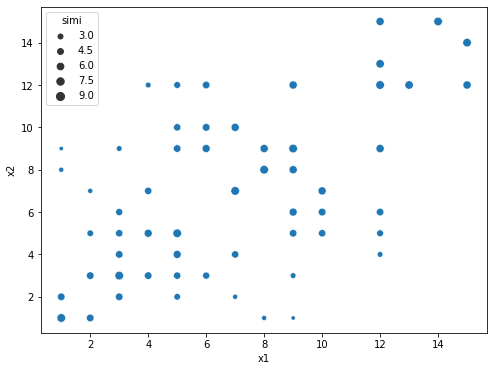

In [1006]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=df['x1'], y=df['x2'], size=df['simi']*10)

In [1058]:
X = df.iloc[:, :-1]
y = df['simi']

In [1059]:
from sklearn.preprocessing import PolynomialFeatures

In [1060]:
poly = PolynomialFeatures(5)
poly.fit(X)

PolynomialFeatures(degree=5)

In [1061]:
X_poly = poly.transform(X)

In [1062]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [1063]:
lm = LinearRegression()
lm.fit(X_poly, y)

LinearRegression()

In [1064]:
y_predict = lm.predict(X_poly)

In [1065]:
from sklearn.metrics import r2_score

In [1066]:
r2_score(y, y_predict)

0.9560202619260455

<AxesSubplot:ylabel='simi'>

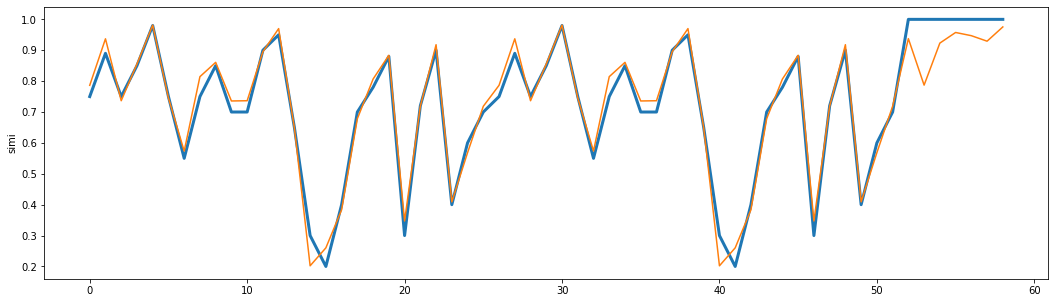

In [1067]:
plt.figure(figsize=(18,5))

sns.lineplot(x=list(range(len(y))), y=y, linewidth=3)
sns.lineplot(x=list(range(len(y))), y=y_predict)

In [1034]:
df = pd.read_excel(r'C:\Users\dcnha\Desktop\nha\rouse image matching\decionsiontree query\COVID cases and deaths by county with population.xlsx')

# cangjie

In [1438]:
def similar(a, b, d_type='jaro'):
    if d_type =='jaro':
        return jaro_winkler(a, b)
    if d_type =='SM':
        return SequenceMatcher(None, a, b).ratio()


def list_word_similarity(p1, p2):
  
    n = len(p1)
    m = len(p2)
    similarity_matrix = np.full(shape=(n, m), fill_value=-1.9)
    for i in range(n):
        for j in range(m):
            similarity_matrix[i][j] = similar(p1[i], p2[j])
    p1_closest = np.max(similarity_matrix, axis=1)
    p2_closest = np.max(similarity_matrix, axis=0)
    p1_mean = np.mean(p1_closest)
    p2_mean = np.mean(p2_closest)
    if n != m:
        sim = np.max([p1_mean, p2_mean])
    else:
        sim = np.mean([p1_mean, p2_mean])
    return sim


In [1458]:
def cangjie_similarity(p1, p2, weight_len_diff=0.4, s_type='cangjie', i=0.4):
    if s_type != 'cangjie':
        p1 = chinese2cangjie(p1)
        p2 = chinese2cangjie(p2)
        
    len1 = len(p1)
    len2 = len(p2)
    len_simi = adapt_len_similarity(len1, len2, i)
    
    string_simi = list_word_similarity(p1, p2)
    
    print('len_simi', len_simi)
    print('OG sim', string_simi)
    
    if len_simi >= string_simi:
        weight_len_diff = 0
    string_simi = string_simi * (1-weight_len_diff) + len_simi * weight_len_diff
    
    return string_simi

In [1459]:
from nha_dimsim import chinese2cangjie

In [1462]:
cangjie_similarity('脆香樂', '脆香乐', s_type='char')

len_simi 1.0
OG sim 0.8518518518518517


0.8518518518518517

In [1461]:
cangjie_similarity('脆香樂', '乐香樂', s_type='char')

len_simi 1.0
OG sim 0.7592592592592592


0.7592592592592592

In [ ]:
# u1 = ['zhuo2', 'mei3', 'ya4', 'huang2',]
# u2 = ['zhuo2', 'mei3', 'ya4', 'he2']

# utterance1 = u1
# utterance2 = u2

# la = []
# lb = []
# for py in u1:
#     la.append(Pinyin(py))
# for py in u2:
#     lb.append(Pinyin(py))


# res = 0.0
# numDiff = 0        
# tot = len(utterance1)*2.1
# for i in range (len(utterance1)):
#     apy = la[i]
#     bpy = lb[i]

#     if (apy is None) or (bpy is None):
#         raise Exception("!Empty Pinyin {},{}".format(la, lb))
#     res += get_edit_distance_close_2d_code(apy, bpy)

#     if apy.consonant != bpy.consonant:
#         numDiff+=1

#     if not(str(apy.vowel) == str(bpy.vowel)):
#         numDiff+=1

#     if apy.tone != bpy.tone:
#         numDiff+=0.01

# diffRatio = (numDiff)/tot
# print(res*diffRatio)

In [ ]:
# def pinyin_similarity(p1, p2):

#     d = get_distance(p1, p2)
#     s = -1 / (1 + np.exp(-d)) + 1.5
    
#     return d, s
# def pinyin_similarity(p1, p2):

#     d = get_distance(p1, p2)
#     if d == 0:
#         s = 1
#     else:
#         s1 = 1 - 1 / (1 + np.exp(-np.log(d)))
        
#         alpha1 = 2.5
#         s2 = 1/(d + alpha1) + (1 - 1/alpha1)
        
#         alpha = 0.05
#         s = alpha * s1 + (1-alpha) *s2
    
#     return d, s